<div style="float: right; margin: 0px 15px 15px 0px;">x
</div>
<h1> Assignment 4 - Convolutional Neural Network </h1>
<em> <strong>Deep Learning - MITxPro </strong></em>
<br><br>
Written by Felipe Dominguez<br>
03/27/23 <br>

In [1]:
# Import packages
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Notice how FashionMNIST is also built into PyTorch!
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

In [3]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


In [4]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


In [5]:
# plot a digit ground truth and autoencoding
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

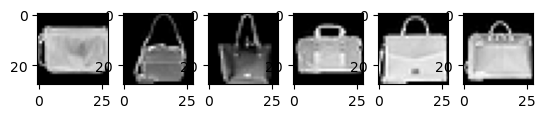

In [6]:
# View 6 bags
view_fashionmnist(8, 6)

In [7]:
# Create a one CNN layer model
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # Split the Encoder and Decoder

        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Linear(8*14*14, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.pipeline(x)


In [8]:
# Create model
learning_rate = 0.001
num_epochs = 10

model = CNNClassifier().to(device)
print(model)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1568, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [9]:
# Train the model
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']
    
    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

In [10]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.5690 Acc: 0.8051
val   Loss: 0.3901 Acc: 0.8653
test  Loss: 0.4150 Acc: 0.8531

Epoch 2/10
----------
train Loss: 0.3673 Acc: 0.8715
val   Loss: 0.3540 Acc: 0.8753
test  Loss: 0.3760 Acc: 0.8636

Epoch 3/10
----------
train Loss: 0.3246 Acc: 0.8845
val   Loss: 0.3246 Acc: 0.8868
test  Loss: 0.3460 Acc: 0.8741

Epoch 4/10
----------
train Loss: 0.2970 Acc: 0.8943
val   Loss: 0.3026 Acc: 0.8948
test  Loss: 0.3228 Acc: 0.8792

Epoch 5/10
----------
train Loss: 0.2765 Acc: 0.9014
val   Loss: 0.2870 Acc: 0.8998
test  Loss: 0.3084 Acc: 0.8839

Epoch 6/10
----------
train Loss: 0.2596 Acc: 0.9071
val   Loss: 0.2784 Acc: 0.9030
test  Loss: 0.3003 Acc: 0.8881

Epoch 7/10
----------
train Loss: 0.2454 Acc: 0.9116
val   Loss: 0.2728 Acc: 0.9037
test  Loss: 0.2959 Acc: 0.8911

Epoch 8/10
----------
train Loss: 0.2327 Acc: 0.9164
val   Loss: 0.2695 Acc: 0.9062
test  Loss: 0.2930 Acc: 0.8929

Epoch 9/10
----------
train Loss: 0.2212 Acc: 0.9207
val   Loss: 0.2668

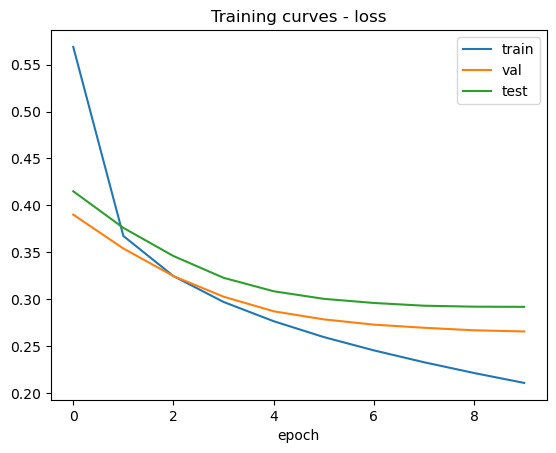

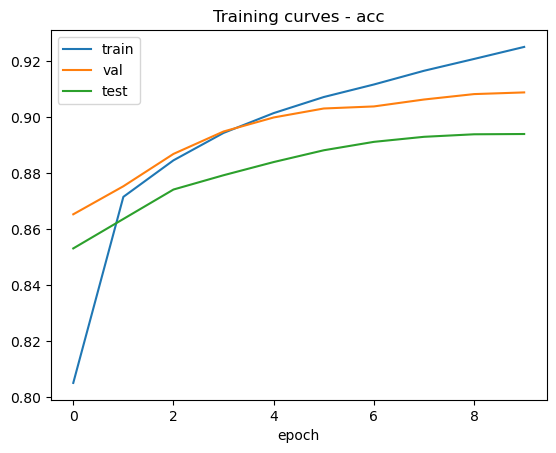

In [11]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

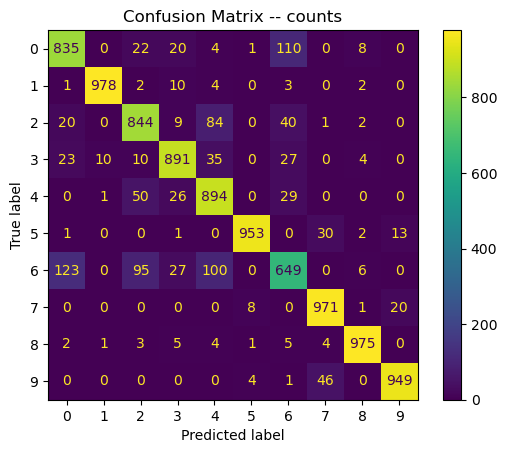

In [12]:
res = plot_cm(model, device, dataloaders, phase='test')

<h1> Conclusion</h1>
Using a single convolutional Neural Network the algorithm achieved an accuracy of ~90.87%. 
The label 6 (shirt) is the most difficult predict. This is most likely due to its simalirity with T-Shirts, Pullover, and coats.

<h1> Assignment 4: Part 2</h1>
Add a second CNN Layer

In [15]:
# Create a 2 CNN layer model    
class CNNClassifier_2cnnlayer(nn.Module):
    def __init__(self):
        super(CNNClassifier_2cnnlayer, self).__init__()
        
        
        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),           
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
             nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.Flatten(),
            nn.Linear(8*14*14, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [16]:
learning_rate = 0.001
num_epochs = 10

model_2layer = CNNClassifier_2cnnlayer().to(device)
print(model_2layer)

CNNClassifier_2cnnlayer(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1568, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [17]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model_2layer.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model_2layer, training_curves = train_classification_model(model_2layer, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.6070 Acc: 0.7851
val   Loss: 0.4269 Acc: 0.8500
test  Loss: 0.4492 Acc: 0.8436

Epoch 2/10
----------
train Loss: 0.3974 Acc: 0.8582
val   Loss: 0.3632 Acc: 0.8724
test  Loss: 0.3823 Acc: 0.8628

Epoch 3/10
----------
train Loss: 0.3424 Acc: 0.8787
val   Loss: 0.3309 Acc: 0.8847
test  Loss: 0.3494 Acc: 0.8736

Epoch 4/10
----------
train Loss: 0.3109 Acc: 0.8883
val   Loss: 0.3109 Acc: 0.8907
test  Loss: 0.3296 Acc: 0.8821

Epoch 5/10
----------
train Loss: 0.2878 Acc: 0.8958
val   Loss: 0.2974 Acc: 0.8928
test  Loss: 0.3165 Acc: 0.8843

Epoch 6/10
----------
train Loss: 0.2697 Acc: 0.9022
val   Loss: 0.2908 Acc: 0.8954
test  Loss: 0.3104 Acc: 0.8879

Epoch 7/10
----------
train Loss: 0.2542 Acc: 0.9074
val   Loss: 0.2853 Acc: 0.8968
test  Loss: 0.3040 Acc: 0.8896

Epoch 8/10
----------
train Loss: 0.2413 Acc: 0.9125
val   Loss: 0.2801 Acc: 0.8989
test  Loss: 0.2996 Acc: 0.8919

Epoch 9/10
----------
train Loss: 0.2287 Acc: 0.9173
val   Loss: 0.2752

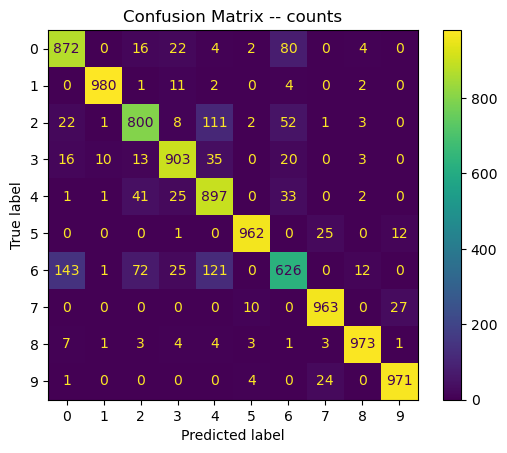

In [18]:
res = plot_cm(model_2layer, device, dataloaders, phase='test')

<h1>Conclusion</h1>
The accuracy for the 2 layer CNN model was 90.13%. Let's check if by using the dropout the accuracy increase.

<h1> Assignment 4 Part 3</h1>

In [19]:
# Using self.dropout = 0.3   
class CNNClassifier_2cnnlayer_dropout(nn.Module):
    def __init__(self):
        super(CNNClassifier_2cnnlayer_dropout, self).__init__()


        self.pipeline = nn.Sequential(
            
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Linear(8*14*14, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
        
    def forward(self, x):
        return self.pipeline(x)


In [20]:
learning_rate = 0.001
num_epochs = 10

model_2layer_dropout = CNNClassifier_2cnnlayer_dropout().to(device)
print(model_2layer_dropout)

CNNClassifier_2cnnlayer_dropout(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [21]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model_2layer_dropout.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model_2layer_dropout, training_curves = train_classification_model(model_2layer_dropout, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.6127 Acc: 0.7828
val   Loss: 0.4202 Acc: 0.8588
test  Loss: 0.4412 Acc: 0.8431

Epoch 2/10
----------
train Loss: 0.3938 Acc: 0.8579
val   Loss: 0.3605 Acc: 0.8791
test  Loss: 0.3788 Acc: 0.8681

Epoch 3/10
----------
train Loss: 0.3546 Acc: 0.8722
val   Loss: 0.3366 Acc: 0.8837
test  Loss: 0.3531 Acc: 0.8729

Epoch 4/10
----------
train Loss: 0.3313 Acc: 0.8788
val   Loss: 0.3204 Acc: 0.8878
test  Loss: 0.3379 Acc: 0.8772

Epoch 5/10
----------
train Loss: 0.3105 Acc: 0.8880
val   Loss: 0.3070 Acc: 0.8923
test  Loss: 0.3258 Acc: 0.8808

Epoch 6/10
----------
train Loss: 0.2963 Acc: 0.8919
val   Loss: 0.2944 Acc: 0.8973
test  Loss: 0.3139 Acc: 0.8839

Epoch 7/10
----------
train Loss: 0.2826 Acc: 0.8960
val   Loss: 0.2884 Acc: 0.8977
test  Loss: 0.3097 Acc: 0.8838

Epoch 8/10
----------
train Loss: 0.2697 Acc: 0.9013
val   Loss: 0.2741 Acc: 0.9038
test  Loss: 0.2982 Acc: 0.8907

Epoch 9/10
----------
train Loss: 0.2595 Acc: 0.9052
val   Loss: 0.2713

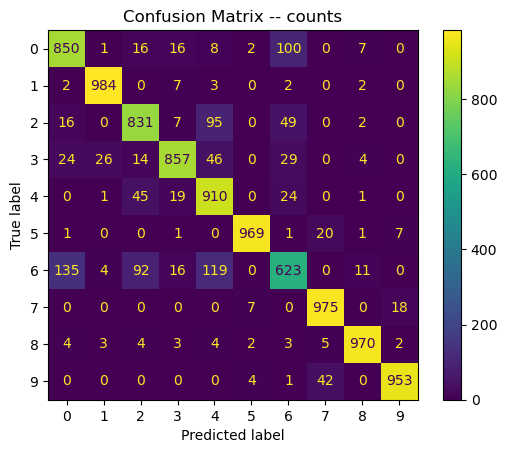

In [22]:
res = plot_cm(model_2layer_dropout, device, dataloaders, phase='test')

<h1>Conclusion</h1>
After applying a dropout with p=0.30, the final accuracy improve to ~90.51. This is not significantly better than the One layer CNN or the two layer CNN.I didn't observe any difference in terms of the clothe that was wrongly predicted the most. It is still the shirt.